# Week 7: Machine Learning

This week we discussed the fundamentals of machine learning and reviewed some common ML algorithms. This notebook will give you more hands-on experience with programming these alogrithms for use in your own research. The goals of this notebook are:

+ Explore convex and nonconvex optimization problems.
+ Use the *scikit-learn* library to perform common ML analyses.
+ Learn how to visualize high dimensional data.
+ Utilize low dimensional representations of data for analyses.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import sklearn as sk
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

# set some style options
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'

## Optimization

Let's look at a very simple optimization problem where we are trying to estimate a model of the form:

$y = bx+e$

where,

+ $y$: dependent variable
+ $x$: independent variable
+ $b$: model parameter to be estimated
+ $e$: measurement error

In class we saw that a common approach to obtaining a parameter estimate $\hat{b}$ is to minimize the mean squared error:

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2$

with $\hat{y_i} = \hat{b}x_i$.

For this exercise, we will be minimizing this error function via gradient descent. Since this is a univariate function, all we need to do is calculate the derivative of MSE with respect to $\hat{b}$, which is given by:

$\frac{\partial MSE}{\partial \hat{b}} = -\frac{2}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)(x_i)$



First, let's simulate some data. The linear regression model will be given by $y = 2x + e$, where $e$ is unbiased normally distributed measurement error.

Text(0.5, 1.0, 'Regression Data')

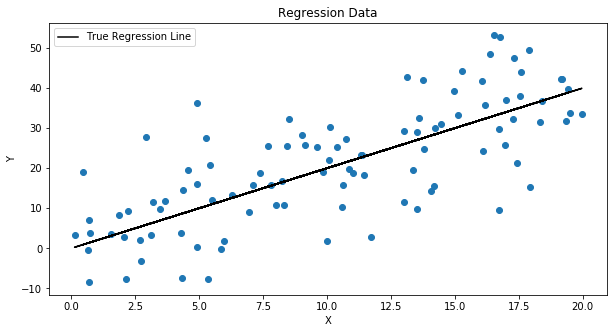

In [3]:
x = np.random.uniform(0,20,100)
b = 2
e = np.random.normal(0,10,len(x))
y = b*x+e

plt.figure(figsize = (10,5))
plt.plot(x,y,'o')
plt.plot(x,b*x,color = 'black',label = "True Regression Line")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Regression Data")

This is a strictly convex optimization problem, which means there is only one minima and it is the global one. We can see this by plotting the MSE for several possible values of $\hat{b}$ (the error landscape). Our job is to find the $\hat{b}$ that results in the minimum MSE.

In [4]:
def MSE(x,y,b_hat):
    n = len(x)
    y_hat = b_hat*x
    return((1/n)*np.sum((y-y_hat)**2))

Text(0.5, 1.0, 'Error Landscape')

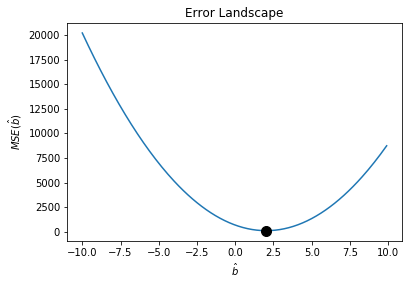

In [5]:
b_hats = np.arange(-10,10,.1) #candidate values of b_hat
errors = [] #array to store MSE values for each b_hat

for b_hat in b_hats:
    errors.append(MSE(x,y,b_hat))

plt.plot(b_hats,errors) #plot MSE for each b_hat
plt.plot(b,MSE(x,y,b),'o',markersize = 10,color = "black") #True value of b
plt.xlabel(r"$\hat{b}$")
plt.ylabel(r"$MSE(\hat{b})$")
plt.title("Error Landscape")

### Exercise 1

##### Convex Optimization
We will perform gradient descent to obtain an estimate $\hat{b}$. You will need to specify a precision value, while the learning rate $\eta$ will be given. If the difference between successive $\hat{b}$'s is less than the precision value, the gradient descent alogrithm has converged to a final estimate. 

In [6]:
def MSE_gradient(x,y,b_hat):
    #Calculates the gradient of MSE for candidate b_hat
    n = len(x)
    y_hat = b_hat*x
    return((-2/n)*np.sum((y-y_hat)*x))

def MSE_GD(precision_value,eta = 0.00001):
    #Performs gradient descent of the MSE
    b_hat = np.random.normal(0,1,1) #initial guess
    converged = False
    while not converged:
        b_hat_new = b_hat-eta*MSE_gradient(x,y,b_hat)
        if np.abs(b_hat_new-b_hat)<precision_value:
            converged = True
        b_hat = b_hat_new
    return(b_hat)

**A.** Run the gradient descent alogrithm twice. For the first estimate, use a precision value of $0.0001$ and $\eta$ of $0.00001$ to obtain an estimate of $\hat{b}$. For the second estimate, use a larger precision value (you choose). Plot and label the first estimated model on the left, the second estimated model in the middle, and the final values of $\hat{b}$ for each estimate on the error landscape on the right. 

#### Nonconvex Optimization

Let's now try a nonconvex optimization problem. Suppose we are trying to estimate a model of the form:

$y = sin(x^b)$

where,
+ $y$: dependent variable
+ $x$: independent variable
+ $b$: model parameter to be estimated

Text(0.5, 1.0, 'Sinusoidal Data')

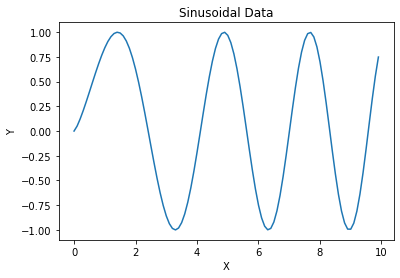

In [7]:
x = np.arange(0.001,10,.1)
b = 1.3
y = np.sin(x**b)
plt.plot(x,y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sinusoidal Data")

Even though we have no measurement error, we'll see that this is a challenging optimization problem when using gradient descent.

We will once again minimize the MSE in order to estimate the unknown model parameter $b$. The derivative of the MSE is a little more complicated now:

$\frac{\partial MSE}{\partial \hat{b}} = -\frac{2}{n} \sum_{i=1}^{n}(y_i-\hat{y}_i)cos(x_i^{\hat{b}})ln(x_i)x_i^{\hat{b}}$

Below are two functions that calculate the MSE and the derivative of the MSE with respect to $\hat{b}$.

In [8]:
def MSE(x,y,b_hat):
    n = len(x)
    y_hat = np.sin(x**(b_hat))
    return((1/n)*np.sum((y-y_hat)**2))

def MSE_gradient(x,y,b_hat):
    n = len(x)
    y_hat = np.sin(x**b_hat)
    return((-2/n)*np.sum((y-y_hat)*np.cos(x**b_hat)*np.log(x)*(x**b_hat)))

### Exercise 2
**A.** Plot the error landscape and put a marker at the true value of $b$. What issues do you foresee when implementing gradient descent on this function?

**B.** Perform gradient descent 3 times to find $\hat{b}$. Each time use a different $\eta$ and precision value of $0.000001$. Plot the error landscape and three estimates of $\hat{b}$ on the right, and the three estimated models on the left.

**C.** Why do you think gradient descent performed so poorly on this problem? Did you notice any effects of how you chose your random initial $\hat{b}$ on alogrithmic performance?

In practice, classical gradient descent is not used since it is easy to get stuck in local minima. Additionally, it becomes computationally expensive when data sets are large. It is more common to see variations of gradient descent such as *stochastic gradient descent* and the *Adam* optimizer.

## Linear Regression via OLS

In Exercise 1, we solved a basic linear regression problem with gradient descent. However, the most common method of estimating regression coefficients is to use the ordinary least squares (OLS) solution. The *scikit-learn* library has many useful functions for machine learning, including fitting linear models. Let's simulate some data and find the model coefficients via OLS estimation.

Text(0.5, 1.0, 'Regression Data')

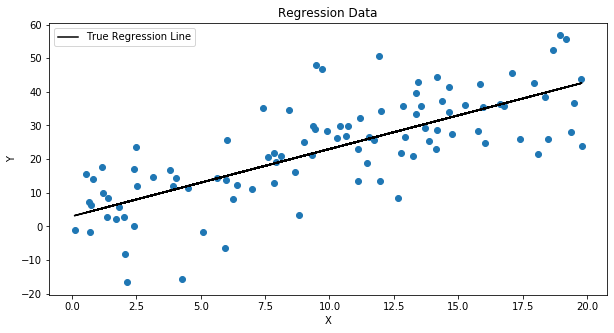

In [9]:
x = np.random.uniform(0,20,100)
b0 = 3 #intercept
b1 = 2 #slope
e = np.random.normal(0,10,len(x))
y = b0+b1*x+e

plt.figure(figsize = (10,5))
plt.plot(x,y,'o')
plt.plot(x,b0+b1*x,color = 'black',label = 'True Regression Line')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Regression Data")

In [10]:
X = x.reshape((-1,1)) #when only one independent variable, sklearn requires this reshaping
model = LinearRegression().fit(X, y) #call linear regression from sklearn
b0_hat = model.intercept_ #estimated intercept
b1_hat = model.coef_[0] #estimated slope

Estimate of b0: 3.608985465624812 
Actual b0: 3

Estimate of b1: 1.9707290431115194 
Actual b1: 2


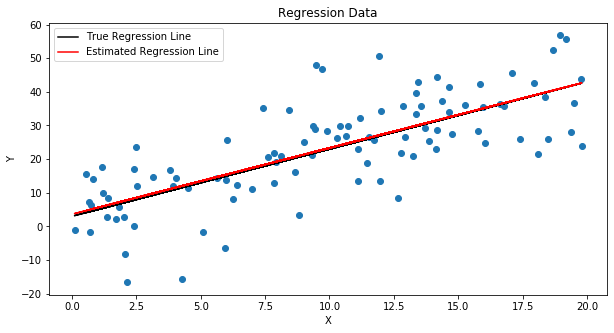

In [11]:
print("Estimate of b0:",b0_hat,"\nActual b0:",b0)
print("\nEstimate of b1:",b1_hat,"\nActual b1:",b1)

y_hat = b0_hat+b1_hat*x

plt.figure(figsize = (10,5))
plt.plot(x,y,'o')
plt.plot(x,b0+b1*x,color = 'black',label = "True Regression Line")
plt.plot(x,y_hat,color = 'red', label = "Estimated Regression Line")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Regression Data")
plt.legend()

We can obtain predictions of our model using the **model.predict()** function. This function will produce predicted $\hat{y}$'s for model inputs using the estimated regression coefficients. Using these predictions, we can calculate fit statistics of our model. 

$R^2$ is the proportion of variance in our dependent variable that can be predicted by our independent variables. We want our $R^2$ to be as close to 1 as possible. Different fields have different criteria for what a "good" $R^2$ is. There are several reasons the $R^2$ of a linear regression could be low. These include:

+ A linear model was not appropriate.
+ The independent variables were not good predictors of our independent variable.
+ The is large amount of measurement error.
+ OLS assumptions were violated.

I encourage you to examine how changing the variance of the measurement error affects the $R^2$ and MSE.


In [12]:
y_hat = model.predict(X)
mse = mean_squared_error(y,y_hat)
r2 = r2_score(y,y_hat)
print("Model MSE:",mse,"\nModel R^2:",r2)

Model MSE: 102.93873827382959 
Model R^2: 0.5539280398363027


*Scikit-learn* comes with datasets commonly used for practicing machine learning and statistical methods. We will run a multiple regression (i.e. regression with multiple independent variables) using the diabetes dataset, where we will predict disease progression.

Below, we will load the data and use the following features:

+ $y$: disease progression in patient (low good, high bad)
+ $age$: age of patient
+ $bmi$: body mass index of patient
+ $bp$: patient blood pressure

In [13]:
x,y = sk.datasets.load_diabetes(return_X_y=True)
age = x[:,0]
bmi = x[:,2]
bp = x[:,3]
X = np.array([age,bmi,bp]).T

## Exercise 3
**A.** Plot three scatter plots of the data, where the x-axis of the scatter plot is an independent variable and the y-axis is the dependent variable.

**B.** Perform a linear regression using the three indepedent variables age, bmi, and bp. Write the regression equation you estimated. Is an increase in age associated with an increase or decrease in disease progression?



**C**. Calculate the MSE and $R^2$ of the regression model.

**D**. In class, we discussed the concept of *regularization*. Ridge regression is a form of regularized regression that corrects for correlations in the data. Rerun the previous analysis using the sklearn Ridge regression model (you should play around with the regularization parameter *alpha*). Calculate the MSE and $R^2$ of this regression model. 

## Logistic Regression

Let's now look at performing classification via logistic regression. We will use the breast cancer dataset to predict the probability of a tumor being malignant ($y = 0$) or benign ($y = 1$) based on tumor features extracted from medical imaging.

Recall that for the case where there is a single independent variable, the model for logistic regression is:

$p(y=1) = (1+exp[-(b_0 + b_1x)])^{-1}$

In [14]:
X,y = sk.datasets.load_breast_cancer(return_X_y=True)
mean_radius = X[:,0]

We can fit a logistic regression model using the mean radius of the tumor as the independent variable. Additionally, we can calculate the **confusion matrix** which tabulates the accuracy of our model.

| $ $| $y$ = 0 | $y$ = 1     |
| :---        |    :----:   |          ---: |
| **$\hat{y}$ = 0**     | True Negative      | False Negative   |
| **$\hat{y}$ = 1**   | False Positive       | True Positive     |

In a perfect world, the confusion matrix would be diagonal. However, you typically have a trade off in the amount of false positives and false negatives. It is your job as a researcher to decide which is worse for a given problem.


## Exercise 4
**A.** Perform a logistic regression predicting $p(y=1)$ using mean radius as the independent variable. Is increased tumor mean radius associated with an increase or decrease in the probability of the tumor being malignant?

**B.** Make a scatter plot with the x-axis mean radius and y-axis class of the tumor. Additionally, plot the sigmoidal curve you obtain from the coefficients you estimated in A.

**C.** Calculate the confusion matrix (**hint**:confusion_matrix($y,\hat{y}$)) and use it to find the accuracy of the model. Is this an acceptable amount of false negatives and false positives to you?

### Testing and Training Sets

An important concept in machine learning (and statistics) is the notion of **overfitting**. This is when your model performs very well on your training data, but has bad performance for out-of-sample data. One solution to detect this is to split your data into **training** and **testing** sets. 

For this next exercise, we will split our data into training and testing sets and predict tumor class using all of the independent variables in the breast cancer dataset. We will remove a random third of the data to be reserved as the testing set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Exercise 5
**A.** Perform a logistic regression on the training data.

**B.** Calculate the confusion matrix for the training data.

**C.** Calculate the confusion matrix for the testing data. Do you think your model was overfitting? Why or why not?

## Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that finds a low dimensional representation of our data while preserving the covariance structure. It does this by projecting the data into a new coordinate system which has a lower dimension than the original data space. 

Each axis (component) in this new coordinate system is found in descending order of variance explained. In other words, the first component explains the most variance in the data and the last component has the smallest amount of variance explained. By dropping components that have very little variance explained, we get a lower dimensional coordinate system.

We will use a dataset of handwritten digits to examine how we can use low dimensional structure in a classification task. First, let's load the data from scikit-learn and split into training and testing sets.

In [16]:
digits = load_digits()
data = digits.data
labels = digits.target
digits_train, digits_test, y_train, y_test = train_test_split(data, labels, test_size=0.4)

Each handwritten digit is given as a vector with 64 elements. We can visualize the data by reshaping each digit into and 8x8 matrix.

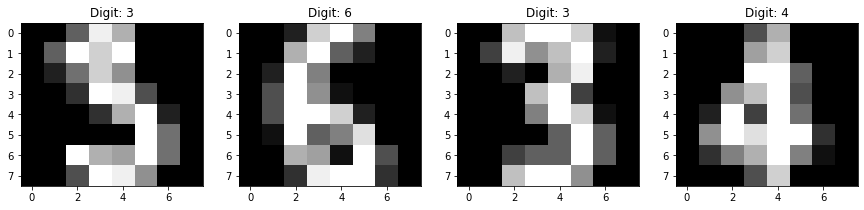

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 4,figsize = (15,3))
for i in range(4):
    ax[i].imshow(digits_train[i,:].reshape((8,8)),cmap = 'gray',origin='upper')
    ax[i].set_title(f'Digit: {y_train[i]}')

Before running PCA, we need to standardize (z-score) our data. If we did not do this, features with more variance would dominate and we may not find the underlying structure.

In [18]:
z_score = StandardScaler()
X_train = z_score.fit_transform(digits_train)
X_test = z_score.fit_transform(digits_test)

The dimensionality of these digits is 64, but we can use PCA to get a lower dimensional representation (sometimes called a latent space). There are many ways to determine how many components you should keep when performing PCA, but one of the easiest is to look at a *scree plot*.

A scree plot shows how much variance is explained by each component in the model. As general rule of thumb, you can use inflection points in the plot to determine how many components you should keep. 

**Note**: Some people use the term scree plot when plotting the eigenvalues of the components instead of the variance explained. When doing so, people may use the 'eigenvalue greater than one' rule and keep all components with an eigenvalue greater than one.

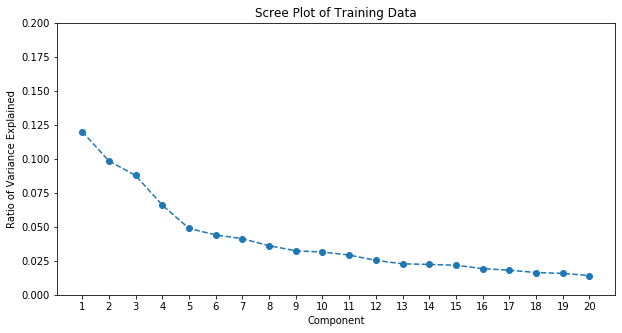

In [19]:
n_components = 20 # initially using a large number of components to get a sense of the data
pca = PCA(n_components=n_components)
pca.fit(X_train)
comp_num = range(1,n_components+1)

plt.figure(figsize = (10,5))
plt.plot(comp_num,pca.explained_variance_ratio_,'--o')
plt.xticks(comp_num)
plt.ylabel('Ratio of Variance Explained')
plt.xlabel('Component')
plt.ylim([0,.2])
plt.title('Scree Plot of Training Data')
plt.show()

After inspecting the scree plot, let's keep five components for our PCA. We will use the training data to find the components and apply the new coordinate system to both the training and testing data. The **fit_transform** function first fits the PCA model and then transforms the data into the new latent space. The **transform** function only applies the transformation. 

In [20]:
pca = PCA(n_components = 5)

train_reduced = pca.fit_transform(X_train)
test_reduced = pca.transform(X_test)

print(f'Original dimensionality: {X_train.shape[1]}')
print(f'New dimensionality: {train_reduced.shape[1]}')

Original dimensionality: 64
New dimensionality: 5


It is common practice to use dimensionality reduction techniques to visualize high dimensional data. In our case, we can use the first two principal components to plot the handwritten digits in a two dimensional representation. A good latent representation will produce similar projections for both the training and testing data.

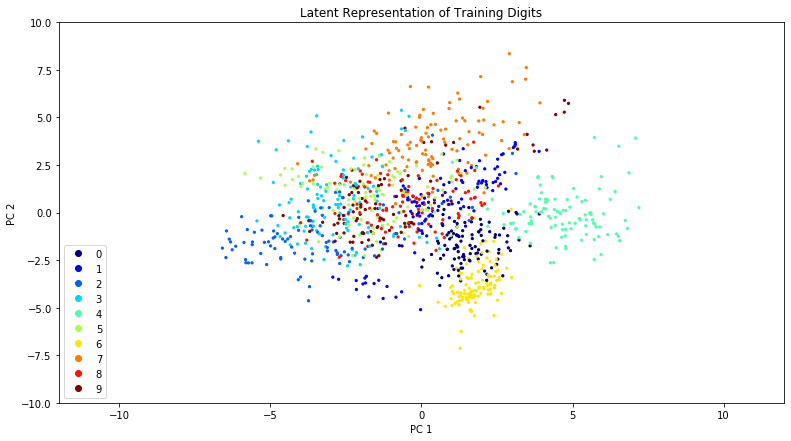

In [21]:
plt.figure(figsize = (13,7))
scatter = plt.scatter(train_reduced[:,0], train_reduced[:,1], s=5, c=y_train)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10),loc = 'lower left')
plt.title('Latent Representation of Training Digits')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.ylim([-10,10])
plt.xlim([-12,12])
plt.show()

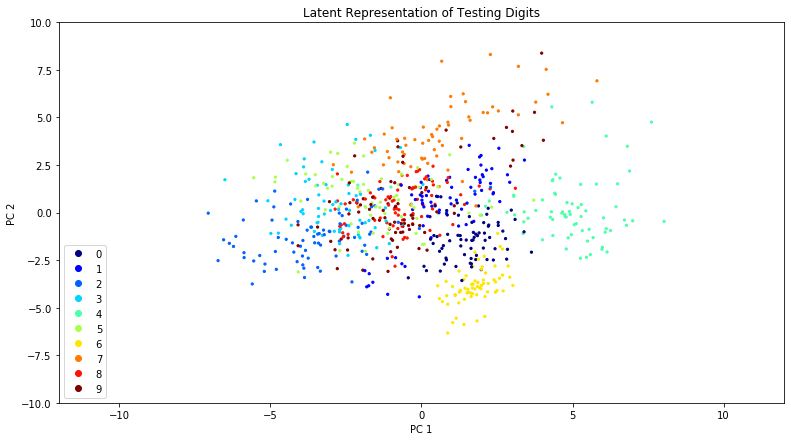

In [22]:
plt.figure(figsize = (13,7))
scatter = plt.scatter(test_reduced[:,0], test_reduced[:,1], s=5, c=y_test)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10),loc = 'lower left')
plt.title('Latent Representation of Testing Digits')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.ylim([-10,10])
plt.xlim([-12,12])
plt.show()

## Support Vector Machine (SVM)

Now that we have a lower dimensional representation of the handwritten digits, we can try and classify the digits using a SVM. 

The function **svm.SVC** is a SVM classifier. You can specify which kernel you want to use with the **kernel** argument, but we will leave it as linear for now.

In [23]:
svm_model = svm.SVC(kernel = 'linear')
svm_model.fit(train_reduced, y_train)

SVC(kernel='linear')

We can get the accuracy of the model using the **predict** function.

In [24]:
train_predicted = svm_model.predict(train_reduced)
test_predicted = svm_model.predict(test_reduced)

training_accuracy = len(train_predicted[train_predicted==y_train])/len(y_train)
testing_accuracy = len(test_predicted[test_predicted==y_test])/len(y_test)

print(f'Accuracy of classifier on training data: {np.round(training_accuracy*100,2)}%')
print(f'Accuracy of classifier on testing data: {np.round(testing_accuracy*100,2)}%')

Accuracy of classifier on training data: 87.48%
Accuracy of classifier on testing data: 82.89%


### Exercise 6
**A.** Rerun the SVM classifier with a *polynomial* kernel. Give the training and testing accuracy of the new classifier.

**B.** Rerun the SVM classifier with a *radial basis function* kernel. Give the training and testing accuracy of the new classifier.

**C.** Using the *radial basis function* kernel, run the SVM classifier using data that has been projected into a two dimensional space (i.e., n_components = 2). Give the training and testing accuracy of the new classifier. Is there a loss in performance by reducing the dimensionality this substantially?

**D.** Rerun the SVM classifier with a *radial basis function* kernel again, but this time use the original 64-dimensional training data. Give the training and testing accuracy of this classifier. Is it much better than using the 5-dimensional representation?